# Signal to Noise ratio

In [1]:
# most common used packages for DSP, have a look into other scipy submodules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

# audio write and play stuff
import soundfile as sf  # requires 'pip install soundfile'
# last tested with soundfile-0.10.3

In [2]:
def my_quant(x, Q):
    r"""Saturated uniform midtread quantizer

    input:
    x  input signal
    Q  number of quantization steps
    output:
    xq quantized signal

    Note: for even Q in order to retain midtread characteristics,
    we must omit one quantization step, either that for lowest or the highest
    amplitudes. Typically the highest signal amplitudes are saturated to
    the 'last' quantization step. Then, in the special case of log2(N)
    being an integer the quantization can be represented with bits.
    """
    tmp = Q//2  # integer div
    quant_steps = (np.arange(Q) - tmp) / tmp  # we don't use this

    # forward quantization, round() and inverse quantization
    xq = np.round(x*tmp) / tmp
    # always saturate to -1
    xq[xq < -1.] = -1.
    # saturate to ((Q-1) - (Q\2)) / (Q\2), note that \ is integer div
    tmp2 = ((Q-1) - tmp) / tmp  # for odd N this always yields 1
    xq[xq > tmp2] = tmp2
    return xq

In [3]:
def check_quant_SNR(x, dBoffset, title):
    print('std: {0:f}, var: {1:f}, mean: {2:f} of x'.format(np.std(x), np.var(x), np.mean(x)))
    Bmax = 24
    SNR = np.zeros(Bmax+1)
    SNR_ideal = np.zeros(Bmax+1)

    for B in range(1, Bmax+1):  # start at 1, since zero Q is not meaningful
        xq = my_quant(x, 2**B)
        SNR[B] = 10*np.log10(np.var(x) / np.var(xq-x))
        SNR_ideal[B] = B*20*np.log10(2) + dBoffset  # 6dB/bit + offset rule

    plt.figure(figsize=(5, 5))
    plt.plot(SNR_ideal, 'o-', label='theoretical', lw=3)
    plt.plot(SNR, 'x-', label='simulation')
    plt.xticks(np.arange(0, 26, 2))
    plt.yticks(np.arange(0, 156, 12))
    plt.xlim(2, 24)
    plt.ylim(6, 148)
    plt.xlabel('number of bits')
    plt.ylabel('SNR / dB')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    print('maximum achievable SNR = {0:4.1f} dB at 24 Bit (i.e. HD audio)'.format(SNR[-1]))    

In [4]:
N = 10000
k = np.arange(N)

std: 0.577350, var: 0.333333, mean: -0.000000 of x
maximum achievable SNR = 144.5 dB at 24 Bit (i.e. HD audio)


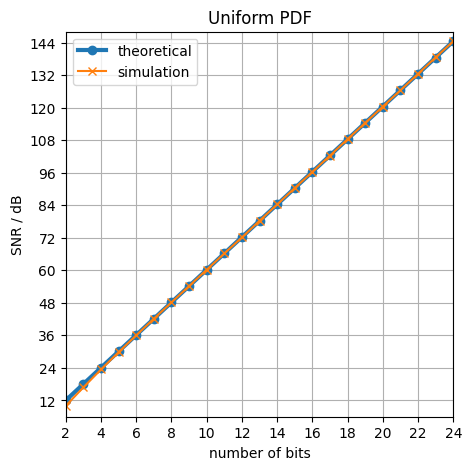

In [5]:
np.random.seed(4)
x = np.random.rand(N)
x -= np.mean(x)
x *= np.sqrt(1/3) / np.std(x)
dBoffset = 0
check_quant_SNR(x, dBoffset, 'Uniform PDF')

std: 0.000000, var: 0.000000, mean: 0.000000 of x
maximum achievable SNR = 14.9 dB at 24 Bit (i.e. HD audio)


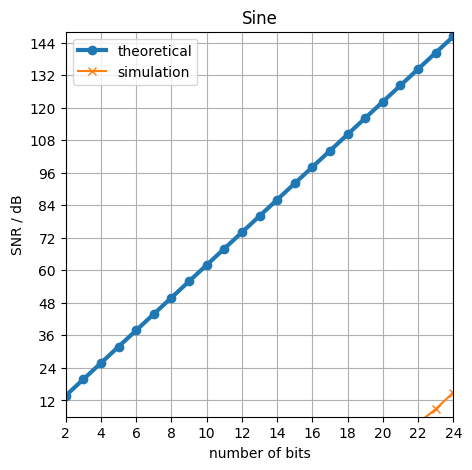

In [11]:
Omega = pow(2*np.pi * 997/44100, 12)  # use a rather odd ratio: e.g. in audio 997 Hz / 44100 Hz
sigma2 = 1/2
dBoffset = -10*np.log10(2 / 3)
x = np.sqrt(2*sigma2) * np.sin(Omega*k)
check_quant_SNR(x, dBoffset, 'Sine')

std: 0.217025, var: 0.047100, mean: -0.000000 of x
maximum achievable SNR = 135.9 dB at 24 Bit (i.e. HD audio)


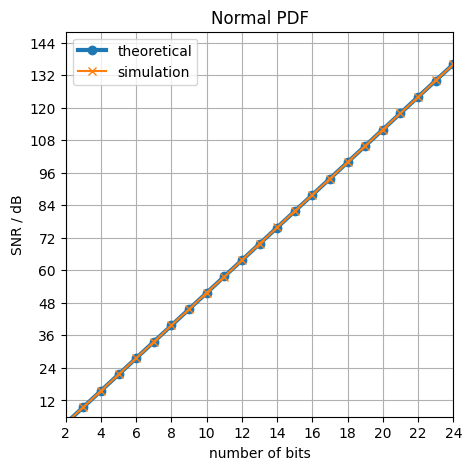

In [7]:
np.random.seed(4)
x = np.random.randn(N)
x -= np.mean(x)
x *= np.sqrt(0.0471) / np.std(x)
dBoffset = -8.5  # from clipping propability 1e-5
check_quant_SNR(x, dBoffset, 'Normal PDF')

std: 0.122837, var: 0.015089, mean: 0.000000 of x
maximum achievable SNR = 131.1 dB at 24 Bit (i.e. HD audio)


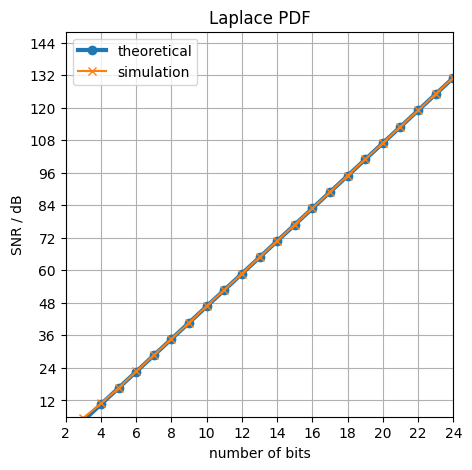

In [9]:
np.random.seed(4)
x = np.random.laplace(size=N)
pClip = 1e-5  # clipping propability
sigma = -np.sqrt(2) / np.log(pClip)
x -= np.mean(x)
x *= sigma / np.std(x)
dBoffset = -13.5  # empircially found for pClip = 1e-5
check_quant_SNR(x, dBoffset, 'Laplace PDF')